# Positivity of automorphic bundles

This note explores the possibility of proving that certain subvarieties of the good reduction of the Siegel variety are of log-general type. More precisely, let $X_g$ be a smooth toroidal compactification of the Siegel variety of genus $g \geq 1$ without level at $p$ over $\mathbb{F}_p$, we conjecture that any good subvariety $V \subset X_g$ such that $\text{codim}(V) \leq g-1$ is of log-general type. To this end, we try to show that the exterior products $\Lambda^k \Omega^1_{X_g}$ of the cotangent bundle are $(\varphi,D)$-ample. These results seems only valid when the $p$ is larger than a specific bound which depends on the dimension of the variety.

In [1]:
import matplotlib.pyplot as plt

class SiegelVariety:
    def __init__(self,g,p):
        if p not in Primes():
            raise ValueError('The number ' + str(p) + ' is not prime')
        self.g = g
        self.p = p
        self.d = int(g*(g+1)/2)
        self.A = WeylCharacterRing(['A',self.g-1])
        self.C = WeylCharacterRing(['C',self.g])
        self.L = RootSystem("A"+str(self.g-1)).ambient_space() #Ag-1
        self.LG = RootSystem("C"+str(self.g)).ambient_space() #Cg
        self.W = WeylGroup(self.L)
        self.WG = WeylGroup(self.LG)

        self.phi_L = self.A.positive_roots()
        self.phi_G = self.C.positive_roots()
        self.Delta_L = self.A.simple_roots()
        self.Delta_G = self.C.simple_roots()
        
        self.s = SymmetricFunctions(QQ).schur()
    
    #Change root convention
    def changeConvention(self,char):
        res = []
        for i in range(self.g-1,-1,-1):
            res.append(-char[i])
        return res
    
    #Test equality of characters
    def equality(self,el1,el2):
        for i in range(self.g):
            if el1[i] != el2[i]:
                return False
        return True
    
    #Test if a list contains an element
    def contains(self,lst,el):
        for x in lst:
            if self.equality(x,el):
                return True
        return False
    
    #Check L-dominance
    def Ldominant(self,char):
        for alpha in self.Delta_L:
            value = 0
            for j in range(self.g):
                value += char[j]*alpha[j]
            if value < 0:
                return False
        return True
    
    def extends_to_I(self, chi, I):
        chi = self.LG(chi).to_weight_space()
        simple = self.Delta_G
        SI = [simple[i] for i in I]
        extends = True
        for alpha in SI:
            alpha = alpha.associated_coroot()
            if chi.symmetric_form(alpha.to_weight_space()) != 0:
                extends = False
                break
        return extends
    
    #If it returns True, it means that the automorphic line bundle of weight char
    #is D-ample on the flag bundle of type I0
    def ample_flag_bundle(self, I0, char):
        char = self.changeConvention(char)
        I0 = [self.g-i for i in I0]
        simple = self.Delta_L
        Iprime = [simple[i] for i in I0]
        if len(I0) >0 and not self.extends_to_I(char,I0):
            raise ValueError('The character '+str(char)+' is not defined on the flag bundle of type '+ str(Iprime))
        if not self.orb_p_close(char):
            return False
        else:
            for alpha in self.phi_G:
                if not self.contains(self.phi_L,alpha):
                    alpha = alpha.associated_coroot()
                    value = 0
                    for j in range(self.g):
                        value += char[j]*alpha[j]
                    if value >= 0:
                        return False
            for alpha in self.Delta_L:
                if alpha not in Iprime:
                    value = 0
                    for j in range(self.g):
                        value += char[j]*alpha[j]
                    if value <= 0:
                        return False
            return True
    
    def ample_shimura(self, char, details = False):
        two_rho = sum(self.phi_L)
        mu = 2*self.L(char)+two_rho
        if details:
            print(mu)
        return self.Ldominant(mu) and self.ample_flag_bundle(I0 = [], char = mu)
    
    def positivity_of_cotangent_bundle(self,codimension):
        k = self.d-codimension
        plethysm = self.s([1]*k).plethysm(self.s[2])
        for char, n in list(plethysm):
            if len(char) <= self.g:
                char_norm = char + [0]*(self.g-len(char))
                res = self.ample_shimura(char_norm)
                print(str(char_norm)+' : '+str(res))
    
    def detailed_plethysm(self,partition):
        codimension = self.d-len(partition)
        plethysm = self.s(partition).plethysm(self.s[2])
        for char, n in list(plethysm):
            if len(char) <= self.g:
                char_norm = char + [0]*(self.g-len(char))
                print(str(char_norm)+' : ')
                res = self.ample_shimura(char_norm, details = True)
                print(res)
                
    def plethysm_pipeline(self, partitions):
        res = self.s[2]
        for p in partitions:
            temp_res = self.s(p).plethysm(res)
            res = 0
            for char, n in list(temp_res):
                if len(char) <= self.g:
                    res += n*self.s(char)
        return res
    
    def orb_p_close(self,char, details = False):
        for w in self.WG:
            for alpha in self.phi_G:
                alpha = alpha.associated_coroot()
                if details:
                    print(alpha)
                v = w.action(alpha)
                num = 0
                for j in range(self.g):
                    num += char[j]*v[j]
                den = 0
                for j in range(self.g):
                    den += char[j]*alpha[j]
                if den != 0:
                    if details:
                        print('numerator : ' +str(num))
                        print('denominator : ' +str(den))
                    if max(num/den,-num/den) > self.p-1:
                        return False
        return True
    
    def print_nabla_p_orb(self,char):
        print(self.orb_p_close(char))
        print('\n')
        V = self.A(char)
        for x in V.weight_multiplicities():
            if self.Ldominant(x):
                print(x)
                print(self.orb_p_close(x))
    
    def plot_orb_p(self,kmin, kmax, char, only_dominant = True, figsize = (12,8)):
        if self.g == 2:
            C_p = []
            C_not_p = []
            V = self.A(char)
            for x in V.weight_multiplicities():
                if not only_dominant or self.Ldominant(x):
                    if self.orb_p_close(x):
                        C_p.append([x[i] for i in range(self.g)])
                    else:
                        C_not_p.append([x[i] for i in range(self.g)])
            C_orb = []
            for k2 in range(kmin,kmax):
                for k1 in range(k2,kmax):
                    if self.orb_p_close([k1,k2]):
                        C_orb.append([k1,k2])
            plt.clf()
            fig = plt.figure(figsize=figsize)
            x, y = zip(*C_orb)
            plt.scatter(x,y, label='Orbitally ' + str(self.p) + '-close' , color = 'c')
            if len(C_p) > 0:
                x, y = zip(*C_p)
                plt.scatter(x,y, label='Orbitally ' + str(self.p) + '-close weight' , color = 'b')
            if len(C_not_p) > 0:
                x, y = zip(*C_not_p)
                plt.scatter(x,y, label='Not orbitally ' + str(self.p) + '-close weight' , color = 'r') 
            plt.legend()
            plt.show()

# Case $g = 2$

In [2]:
X = SiegelVariety(g = 2, p = 11)

In [3]:
X.positivity_of_cotangent_bundle(codimension = 0)

[3, 3] : True


In [4]:
X.positivity_of_cotangent_bundle(codimension = 1)

[3, 1] : True


In [5]:
X.positivity_of_cotangent_bundle(codimension = 2)

[2, 0] : False


In [6]:
X.ample_shimura((3,1), details = True)

(7, 1)


True

We explore the $p$-orbitally close characters $\lambda = (k_1,k_2)$ for which all weights of $\nabla(\lambda)$ are again orbitally $p$-close since this is not always the case

In [7]:
X.print_nabla_p_orb([11,3])

True


(11, 3)
True
(10, 4)
True
(9, 5)
True
(8, 6)
True
(7, 7)
True


<Figure size 432x288 with 0 Axes>

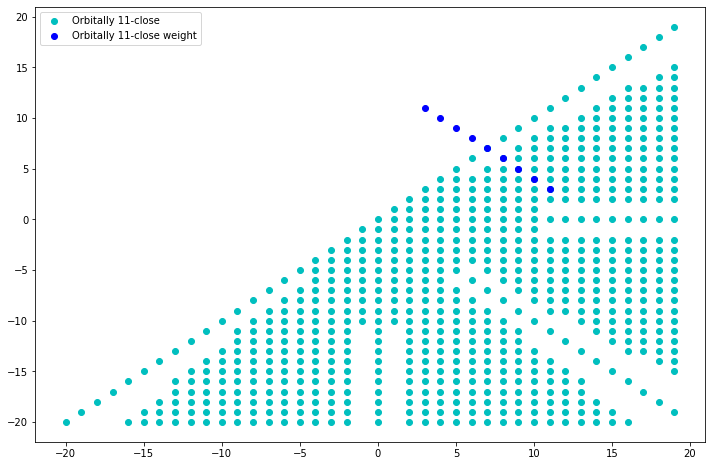

In [8]:
X.plot_orb_p(-20,20,[11,3], only_dominant=False)

In [9]:
X.print_nabla_p_orb([35,-5])

True


(35, -5)
True
(34, -4)
True
(33, -3)
False
(32, -2)
False
(31, -1)
False
(30, 0)
True
(29, 1)
False
(28, 2)
False
(27, 3)
True
(26, 4)
True
(25, 5)
True
(24, 6)
True
(23, 7)
True
(22, 8)
True
(21, 9)
True
(20, 10)
True
(19, 11)
True
(18, 12)
True
(17, 13)
True
(16, 14)
False
(15, 15)
True


<Figure size 432x288 with 0 Axes>

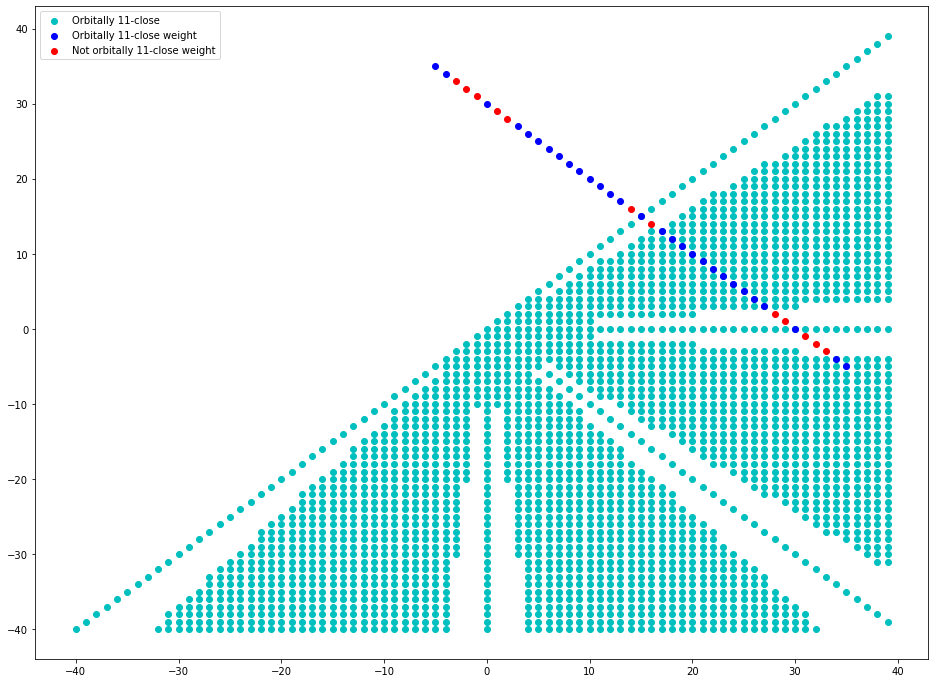

In [10]:
X.plot_orb_p(-40,40,[35,-5], only_dominant=False, figsize = (16,12))

# Case $g = 3$

In [11]:
g = 3
d = int(g*(g+1)/2)
for codim in range(d):
    X = SiegelVariety(g = g, p = 17)
    print(str(codim)+' : ')
    X.positivity_of_cotangent_bundle(codim)

0 : 
[4, 4, 4] : True
1 : 
[4, 4, 2] : True
2 : 
[4, 3, 1] : False
3 : 
[4, 1, 1] : False
[3, 3, 0] : False
4 : 
[3, 1, 0] : False
5 : 
[2, 0, 0] : False


In the case where the codimension of $V$ is $2$, we do not get the $(\varphi,D)$-ampleness. Let's try to use a different Schur functor of the same length.

In [12]:
X.detailed_plethysm([2,2,2,2])

[8, 6, 2] : 
(18, 12, 2)
True
[7, 6, 3] : 
(16, 12, 4)
True
[8, 4, 4] : 
(18, 8, 6)
True
[6, 6, 4] : 
(14, 12, 6)
True


It works, with $S_{(2,2,2,2)}$ we only get $(\varphi,D)$-ample bundles

In [13]:
X.detailed_plethysm([2,2,2])

[7, 4, 1] : 
(16, 8, 0)
False
[8, 2, 2] : 
(18, 4, 2)
True
[6, 4, 2] : 
(14, 8, 2)
True
[4, 4, 4] : 
(10, 8, 6)
True
[6, 6, 0] : 
(14, 12, -2)
False


It doesn't seem to work in codimension $3$

# Case $g = 4$

In [14]:
g = 4
d = int(g*(g+1)/2)
X = SiegelVariety(g = g, p = 31)
for codim in range(d):
    print(str(codim)+' : ')
    X.positivity_of_cotangent_bundle(codim)

0 : 
[5, 5, 5, 5] : True
1 : 
[5, 5, 5, 3] : True
2 : 
[5, 5, 4, 2] : True
3 : 
[5, 4, 4, 1] : False
[5, 5, 2, 2] : True
4 : 
[5, 4, 2, 1] : False
[4, 4, 4, 0] : False
5 : 
[5, 3, 1, 1] : False
[4, 4, 2, 0] : False
6 : 
[5, 1, 1, 1] : False
[4, 3, 1, 0] : False
7 : 
[4, 1, 1, 0] : False
[3, 3, 0, 0] : False
8 : 
[3, 1, 0, 0] : False
9 : 
[2, 0, 0, 0] : False


It doesn't work in codimension $3$. We need to try other partitions.

In [15]:
X.detailed_plethysm([2,2,2,2,2,2,2])

[10, 8, 8, 2] : 
(23, 17, 15, 1)
True
[10, 9, 6, 3] : 
(23, 19, 11, 3)
True
[9, 9, 7, 3] : 
(21, 19, 13, 3)
True
[9, 8, 8, 3] : 
(21, 17, 15, 3)
True
[10, 10, 4, 4] : 
(23, 21, 7, 5)
True
[10, 8, 6, 4] : 
(23, 17, 11, 5)
True
[9, 8, 7, 4] : 
(21, 17, 13, 5)
True
[8, 8, 8, 4] : 
(19, 17, 15, 5)
True
[9, 9, 5, 5] : 
(21, 19, 9, 7)
True
[9, 8, 6, 5] : 
(21, 17, 11, 7)
True
[9, 7, 7, 5] : 
(21, 15, 13, 7)
True
[10, 6, 6, 6] : 
(23, 13, 11, 9)
True
[8, 8, 6, 6] : 
(19, 17, 11, 9)
True
[7, 7, 7, 7] : 
(17, 15, 13, 11)
True


It works ! We used $p = 31$

We will try with a different method

In [16]:
X = SiegelVariety(g = 4, p = 31)

In [17]:
X.plethysm_pipeline([7*[1],[2]])

s[7, 7, 7, 7] + 2*s[8, 8, 6, 6] + s[8, 8, 8, 4] + s[9, 7, 6, 6] + 2*s[9, 7, 7, 5] + 2*s[9, 8, 6, 5] + 2*s[9, 8, 7, 4] + s[9, 8, 8, 3] + 2*s[9, 9, 5, 5] + s[9, 9, 6, 4] + 2*s[9, 9, 7, 3] + s[10, 6, 6, 6] + s[10, 7, 6, 5] + 3*s[10, 8, 6, 4] + s[10, 8, 8, 2] + s[10, 9, 6, 3] + s[10, 10, 4, 4]

# Case $g = 5$

In [57]:
g = 5
d = int(g*(g+1)/2)
X = SiegelVariety(g = g, p = 67)
for codim in range(d):
    print(str(codim)+' : ')
    X.positivity_of_cotangent_bundle(codim)

0 : 
[6, 6, 6, 6, 6] : True
1 : 
[6, 6, 6, 6, 4] : True
2 : 
[6, 6, 6, 5, 3] : True
3 : 
[6, 6, 5, 5, 2] : False
[6, 6, 6, 3, 3] : True
4 : 
[6, 5, 5, 5, 1] : False
[6, 6, 5, 3, 2] : False
5 : 
[6, 5, 5, 3, 1] : False
[6, 6, 4, 2, 2] : False
[5, 5, 5, 5, 0] : False
6 : 
[6, 5, 4, 2, 1] : False
[6, 6, 2, 2, 2] : False
[5, 5, 5, 3, 0] : False
7 : 
[6, 4, 4, 1, 1] : False
[6, 5, 2, 2, 1] : False
[5, 5, 4, 2, 0] : False
8 : 
[6, 4, 2, 1, 1] : False
[5, 4, 4, 1, 0] : False
[5, 5, 2, 2, 0] : False
9 : 
[6, 3, 1, 1, 1] : False
[5, 4, 2, 1, 0] : False
[4, 4, 4, 0, 0] : False
10 : 
[6, 1, 1, 1, 1] : False
[5, 3, 1, 1, 0] : False
[4, 4, 2, 0, 0] : False
11 : 
[5, 1, 1, 1, 0] : False
[4, 3, 1, 0, 0] : False
12 : 
[4, 1, 1, 0, 0] : False
[3, 3, 0, 0, 0] : False
13 : 
[3, 1, 0, 0, 0] : False
14 : 
[2, 0, 0, 0, 0] : False


In [ ]:
X = SiegelVariety(g = 5, p = 67)
X.detailed_plethysm([2]*12)

It is not enough and the program is too slow to test other partitions.